<a href="https://colab.research.google.com/github/maycmesquia/Kaggle_Competition/blob/main/2022_09_Tabular_Playground_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dados e Contatos

Ola, sou *Maycon Douglas*, Cientista Contábil e Cientista de Dados (Data Scientist)!

Acredito fortemente que: conhecer a causa é mais importante para solucionar o problema!

Cada vez mais devemos buscar informação e conhecimento, pois e atraves deles que podemos discernir o boato do fato, a verdade da mentira!

**Contatos:**

- [Kaggle](https://www.kaggle.com/maycondsmendes)

- [Linkedin](https://www.linkedin.com/in/maycon-douglas-data-science/)

- [Github](https://github.com/maycmesquia)

- E-mail: [maycmesquita@gmail.com](https://maycmesquita@gmail.com)

# Tabular Playgroud Series

Competição do [Kaggle](https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/overview)

As lojas concorrentes da Kaggle que vimos no Tabular Playground de janeiro estão de volta. Desta vez, eles estão vendendo livros!

A tarefa para as competições deste mês é um pouco mais complicada. Não apenas há seis países e quatro livros para prever, mas você está sendo solicitado a prever as vendas durante o tumultuado ano de 2021. Você pode usar suas habilidades de ciência de dados para prever as vendas de livros quando as condições estão longe do comum?

Avaliação 

As submissões são avaliadas no SMape entre as previsões e os valores reais. Definimos SMAPE = 0 quando os valores real e previsto são ambos 0.

Arquivo de envio
Para cada um row_idno conjunto de teste, você deve prever o num_sold. O arquivo deve conter um cabeçalho e ter o seguinte formato:

- row_id,num_sold
- 70128,100
- 70129,100
- 70130,100

etc.


## Preparando ambiente

In [ ]:
# Blibiotecas Basicas!

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import normaltest

# Bibliotecas de Aprendizagem!

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression


from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Criando Funções

def avaliacao(estimador, X_train, X_val, y_train, y_val):
    """
    Para avaliar o estimador, ele solicita as seguintes dados:
    estimador, X_train, X_val, y_train, y_val
    """

    y_pred_train = estimador.predict(X_train)
    y_pred_val = estimador.predict(X_val)

    smap_train = mean_absolute_percentage_error(y_train, y_pred_train)
    smap_val = mean_absolute_percentage_error(y_val, y_pred_val)
    
    residuo_train = y_train - y_pred_train
    residuo_val = y_val - y_pred_val
    
    _, p_train = normaltest(residuo_train)
    _, p_val = normaltest(residuo_val)
    
    print("Média de Residuos (Quanto mais proximo de zero melhor)")
    print(f"Residuo Treino: {residuo_train.mean():.8} \nResiduo Valid: {residuo_val.mean():.8} \n")
    print("Teste de distribuição normal (Pvalor < 0.05)")
    print(f"Pvalor Treino: {p_train: .8} \nPvalor Valid: {p_val: .8}")
    print("\nSMAP (Quanto menor melhor)")
    print(f"Treino: {100 * smap_train: .8} \nValid: {100 * smap_val: .8}")
    print(" \n ")
    
    janela, graficos = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
    sns.scatterplot(x=y_val, y=residuo_val, ax=graficos[0][0])
    sns.histplot(residuo_val, kde=True, ax=graficos[0][1])
    
    sns.scatterplot(x=y_train, y=residuo_train, ax=graficos[1][0])
    sns.histplot(residuo_train, kde=True, ax=graficos[1][1])
    plt.tight_layout()


def submissao(estimador, X_test, id_test, cabecalho, nome):
    """
    Para criar o arquivo que ira ser submetido na competição Kaggle
    Solicita os seguintes parametros: estimador, X_test, id_test, cabecalho, nome
    """
    y_proba = estimador.predict(X_test)
    comp = ".csv"
    local = 'Submissoes/'
    pd.Series(y_proba, index=id_test, name=cabecalho).to_csv(end + local + nome + comp, header=True)
    print(f'Arquivo salvo com sucesso! em: {end + local}')

def val_split(train, test, Id, variavel_dependente, features_drop=None):
    """
    Retorna: X_train, X_val, X_test, y_train, y_val
    features_drop: variaveis que deverão ser excluidas da base.
    """
    if features_drop != None:
        drop = list(features_drop)
    elif features_drop == None:
        drop = list()
        drop.append(Id)

    X_test = test.drop(columns=drop)

    drop.append(variavel_dependente)

    X = train.drop(columns=drop)
    y = train[variavel_dependente]
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    return X_train, X_val, X_test, y_train, y_val
      
    
def feature_cat_num(X_train):
    
    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()
    features_num = X_train.select_dtypes(include=np.number).columns.tolist()
    
    return features_cat, features_num

def transformer(X_train):
    
    features_cat, features_num = feature_cat_num(X_train)
    
    pipe_cat = Pipeline([('input_cat', SimpleImputer(strategy='constant', fill_value='unknown')),
                    ('onehot', OneHotEncoder())])
    
    pipe_num = Pipeline([('input_num', SimpleImputer(strategy='mean')),
                     ('std', StandardScaler())])
    
    pre_process = ColumnTransformer([('transform_num', pipe_num, features_num),
                                     ('transform_cat', pipe_cat, features_cat)])
    
    return pre_process

## Outras Bibliotecas!

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [ ]:
# Geralzão ! Clean

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.pipeline import Pipeline

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

import pickle

## Dados Colab Google

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
end = '/content/drive/Othercomputers/Meu laptop/Dados/2022.09 - Tabular Playgroud Series/'
train = pd.read_csv(end + 'Dados/train.csv')
test = pd.read_csv(end + 'Dados/test.csv')

## Dados Jupyter Lab

In [ ]:
end = ''
train = pd.read_csv("Dados/train.csv")
test = pd.read_csv("Dados/test.csv")

## Objetivos:

Realizar uma submissão com um SMape, que me permita ficar entre os primeiros 75% da liderboard.

## Analisando os dados

In [ ]:
train['date'] = pd.to_datetime(train['date'])
train.set_index('date', inplace=True)
train

,row_id,country,store,product,num_sold
date,,,,,
2017-01-01,0,Belgium,KaggleMart,Kaggle Advanced Techniques,663
2017-01-01,1,Belgium,KaggleMart,Kaggle Getting Started,615
2017-01-01,2,Belgium,KaggleMart,Kaggle Recipe Book,480
2017-01-01,3,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
2017-01-01,4,Belgium,KaggleRama,Kaggle Advanced Techniques,240
...,...,...,...,...,...
2020-12-31,70123,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
2020-12-31,70124,Spain,KaggleRama,Kaggle Advanced Techniques,215
2020-12-31,70125,Spain,KaggleRama,Kaggle Getting Started,158


In [ ]:
test['date'] = pd.to_datetime(test['date'])
test.set_index('date', inplace=True)
test

,row_id,country,store,product
date,,,,
2021-01-01,70128,Belgium,KaggleMart,Kaggle Advanced Techniques
2021-01-01,70129,Belgium,KaggleMart,Kaggle Getting Started
2021-01-01,70130,Belgium,KaggleMart,Kaggle Recipe Book
2021-01-01,70131,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
2021-01-01,70132,Belgium,KaggleRama,Kaggle Advanced Techniques
...,...,...,...,...
2021-12-31,87643,Spain,KaggleMart,Kaggle for Kids: One Smart Goose
2021-12-31,87644,Spain,KaggleRama,Kaggle Advanced Techniques
2021-12-31,87645,Spain,KaggleRama,Kaggle Getting Started


In [ ]:
train.columns

Index(['row_id', 'country', 'store', 'product', 'num_sold'], dtype='object')

In [ ]:
test.columns

Index(['row_id', 'country', 'store', 'product'], dtype='object')

In [ ]:
train['country'].unique()

array(['Belgium', 'France', 'Germany', 'Italy', 'Poland', 'Spain'],
      dtype=object)

In [ ]:
pd.DataFrame([train.nunique(), train.dtypes, train.isna().sum()], index=["Dados Unicos", "Tipo de Dado", "Valores Ausentes NaN"]).T

,Dados Unicos,Tipo de Dado,Valores Ausentes NaN
row_id,70128,int64,0
country,6,object,0
store,2,object,0
product,4,object,0
num_sold,699,int64,0


In [ ]:
pd.DataFrame([test.nunique(), test.dtypes, test.isna().sum()], index=["Dados Unicos", "Tipo de Dado", "Valores Ausentes NaN"]).T

,Dados Unicos,Tipo de Dado,Valores Ausentes NaN
row_id,17520,int64,0
country,6,object,0
store,2,object,0
product,4,object,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70128 entries, 2017-01-01 to 2020-12-31
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   country   70128 non-null  object
 2   store     70128 non-null  object
 3   product   70128 non-null  object
 4   num_sold  70128 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.2+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2021-01-01 to 2021-12-31
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   row_id   17520 non-null  int64 
 1   country  17520 non-null  object
 2   store    17520 non-null  object
 3   product  17520 non-null  object
dtypes: int64(1), object(3)
memory usage: 684.4+ KB


### Avaliando as Features!

In [ ]:
for feature in test.columns:
    print(f'{feature} : {test[feature].unique()}')

row_id : [70128 70129 70130 ... 87645 87646 87647]
country : ['Belgium' 'France' 'Germany' 'Italy' 'Poland' 'Spain']
store : ['KaggleMart' 'KaggleRama']
product : ['Kaggle Advanced Techniques' 'Kaggle Getting Started'
 'Kaggle Recipe Book' 'Kaggle for Kids: One Smart Goose']


<AxesSubplot:xlabel='num_sold', ylabel='Count'>

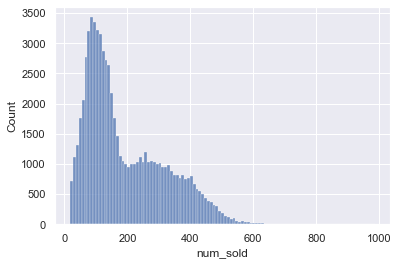

In [ ]:
sns.histplot(data=train, x='num_sold')

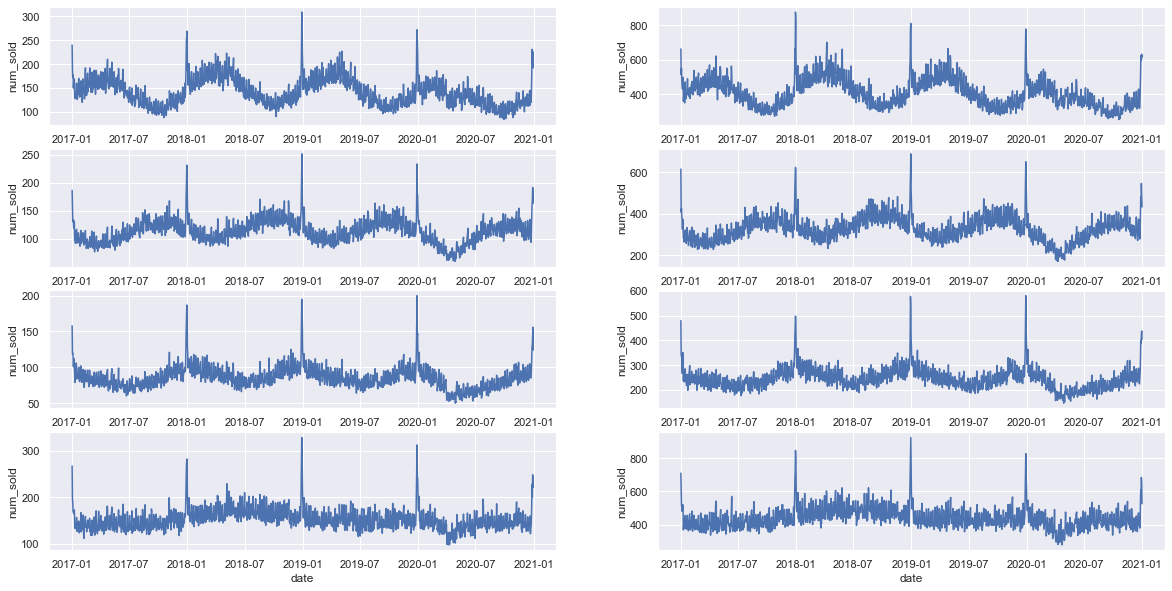

In [ ]:
janela, graficos = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))

filtro_1 = (train['store'] == 'KaggleRama') & (train['country'] == 'Belgium')
filtro_2 = (train['store'] == 'KaggleMart') & (train['country'] == 'Belgium')

sns.lineplot(data=train[filtro_1 & (train['product'] == 'Kaggle Advanced Techniques' )],x='date', y='num_sold', ax=graficos[0][0])
sns.lineplot(data=train[filtro_2 & (train['product'] == 'Kaggle Advanced Techniques' )],x='date', y='num_sold', ax=graficos[0][1])
sns.lineplot(data=train[filtro_1 & (train['product'] == 'Kaggle Getting Started' )],x='date', y='num_sold', ax=graficos[1][0])
sns.lineplot(data=train[filtro_2 & (train['product'] == 'Kaggle Getting Started' )],x='date', y='num_sold', ax=graficos[1][1])
sns.lineplot(data=train[filtro_1 & (train['product'] == 'Kaggle Recipe Book' )],x='date', y='num_sold', ax=graficos[2][0])
sns.lineplot(data=train[filtro_2 & (train['product'] == 'Kaggle Recipe Book' )],x='date', y='num_sold', ax=graficos[2][1])
sns.lineplot(data=train[filtro_1 & (train['product'] == 'Kaggle for Kids: One Smart Goose' )],x='date', y='num_sold', ax=graficos[3][0])
sns.lineplot(data=train[filtro_2 & (train['product'] == 'Kaggle for Kids: One Smart Goose' )],x='date', y='num_sold', ax=graficos[3][1])

plt.show()

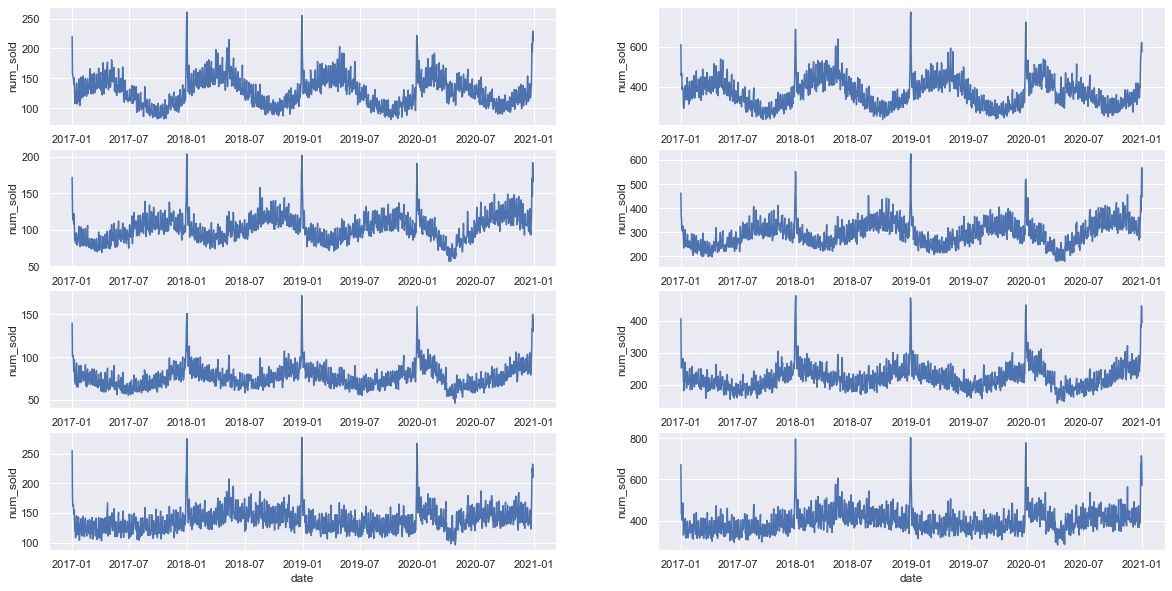

In [ ]:
janela, graficos = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))

filtro_1 = (train['store'] == 'KaggleRama') & (train['country'] == 'France')
filtro_2 = (train['store'] == 'KaggleMart') & (train['country'] == 'France')

i = 0
for livro in train['product'].unique():
    sns.lineplot(data=train[filtro_1 & (train['product'] == livro )],x='date', y='num_sold', ax=graficos[i][0])
    sns.lineplot(data=train[filtro_2 & (train['product'] == livro )],x='date', y='num_sold', ax=graficos[i][1])
    i+=1

plt.show()

<AxesSubplot:xlabel='date', ylabel='num_sold'>

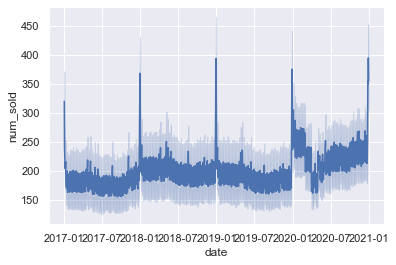

In [ ]:
sns.lineplot(data=train, x='date', y='num_sold')

In [ ]:
train.groupby([ 'store'])['num_sold'].sum()

store
KaggleMart    10117254
KaggleRama     3508405
Name: num_sold, dtype: int64

In [ ]:
train.groupby([ 'product'])['num_sold'].sum()

product
Kaggle Advanced Techniques          3913910
Kaggle Getting Started              3136903
Kaggle Recipe Book                  2349817
Kaggle for Kids: One Smart Goose    4225029
Name: num_sold, dtype: int64

In [ ]:
train.groupby([ 'country'])['num_sold'].sum()

country
Belgium    2781050
France     2512319
Germany    2786415
Italy      2201092
Poland     1341545
Spain      2003238
Name: num_sold, dtype: int64

In [ ]:
df_train = train.copy()
df_train.replace({'store': {'KaggleMart': 2, 'KaggleRama': 1},
                  'product': {'Kaggle for Kids: One Smart Goose': 4, 'Kaggle Advanced Techniques': 3, 'Kaggle Getting Started': 2, 'Kaggle Recipe Book': 1 },
                  'country': {'Germany': 6, 'Belgium': 5, 'France': 4, 'Italy': 3, 'Spain': 2, 'Poland': 1}},
                  inplace=True)

df_train.head()

,row_id,country,store,product,num_sold
date,,,,,
2017-01-01,0,5,2,3,663
2017-01-01,1,5,2,2,615
2017-01-01,2,5,2,1,480
2017-01-01,3,5,2,4,710
2017-01-01,4,5,1,3,240


In [ ]:
df_test = test.copy()
df_test.replace({'store': {'KaggleMart': 2, 'KaggleRama': 1},
                  'product': {'Kaggle for Kids: One Smart Goose': 4, 'Kaggle Advanced Techniques': 3, 'Kaggle Getting Started': 2, 'Kaggle Recipe Book': 1 },
                  'country': {'Germany': 6, 'Belgium': 5, 'France': 4, 'Italy': 3, 'Spain': 2, 'Poland': 1}},
                  inplace=True)

df_test.head()

,row_id,country,store,product
date,,,,
2021-01-01,70128,5,2,3
2021-01-01,70129,5,2,2
2021-01-01,70130,5,2,1
2021-01-01,70131,5,2,4
2021-01-01,70132,5,1,3


## Sample Submission

A sample submission teve o desempenho de 0.50000 de score ROC

In [ ]:
SMape = 65,86858

## Criando o modelo basico

Como modelo inicial iremos utilizar o Hist Gradient Boosting Classifier
ele permite consegue utilizar dados ausentes para treinar o modelo.

Iremos desconciderar todos as features categoricas.

In [ ]:
drop = ['row_id', 'num_sold']
X = df_train.drop(columns=drop, axis=1)
y = df_train['num_sold']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

dados_split = (X_train, X_val, y_train, y_val)
dados_train = (X_train, y_train)
dados_val = (X_val, y_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((56102, 3), (56102,), (14026, 3), (14026,))

Média de Residuos (Quanto mais proximo de zero melhor)
Residuo Treino: 5.3812891e-14 
Residuo Valid: -1.0615589 

Teste de distribuição normal (Pvalor < 0.05)
Pvalor Treino:  0.0 
Pvalor Valid:  0.0

SMAP (Quanto menor melhor)
Treino:  32.430015 
Valid:  32.335064
 
 
Wall time: 2.44 s


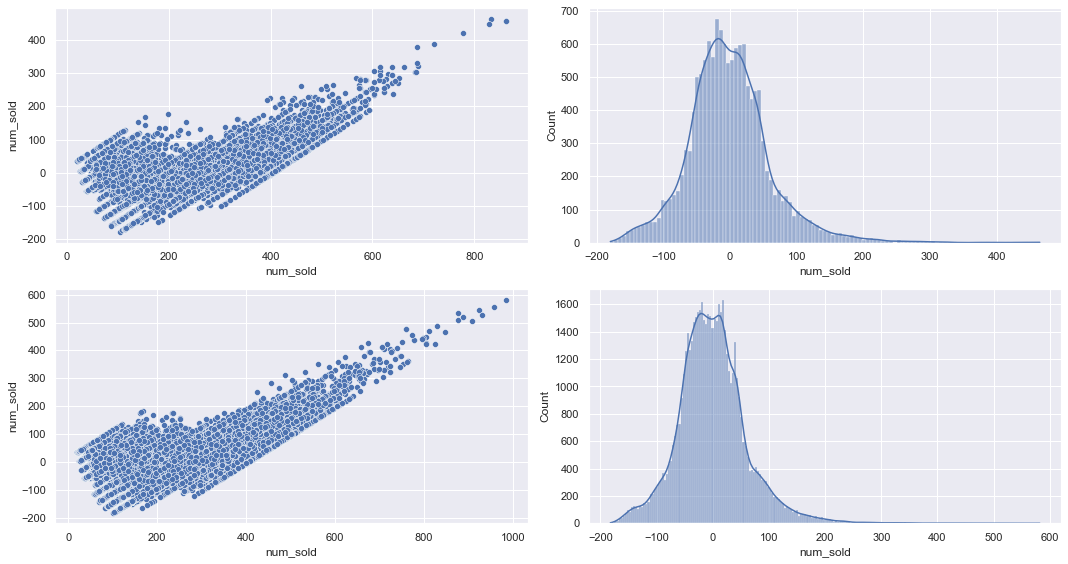

In [ ]:
%%time

modelo_basico = LinearRegression().fit(X_train, y_train)

avaliacao(modelo_basico, *dados_split)

### Avaliando o estimador

A submissão da previsão gerada pelo modelo Linear Regression deu um SMAP de 36.26685

In [ ]:
drop = ['row_id', 'date']
X_test = df_test.drop(drop, axis=1)

id_test = df_test['row_id']
cabecalho = 'num_sold'
submissao(modelo_basico, X_test, id_test, cabecalho=cabecalho, nome='Modelo_Basico')

Arquivo salvo com sucesso! em: /content/drive/Othercomputers/Meu laptop/Dados/2022.09 - Tabular Playgroud Series/Submissoes/


## Melhorando os dados!


## Utilizando todos os dados!

Os dados apresentados tem caracteristicas de series temporais, com isso utilisarei os dados dos dias anteriores (3 dias) afim de aumentar a base, e tambem uma média de vendas dos ultimos 5 dias!

Lembrar tambem que há mais de uma serie temporal, devemos nos ater ao fato de que cada pais(country), loja(store) e livro(product) gera uma seria individual.

Com isso temos o total de 6(product) x 2(store) x 4(country) = 48 series independentes!

In [ ]:
df_train = train.copy()

df_train

,row_id,country,store,product,num_sold
date,,,,,
2017-01-01,0,Belgium,KaggleMart,Kaggle Advanced Techniques,663
2017-01-01,1,Belgium,KaggleMart,Kaggle Getting Started,615
2017-01-01,2,Belgium,KaggleMart,Kaggle Recipe Book,480
2017-01-01,3,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
2017-01-01,4,Belgium,KaggleRama,Kaggle Advanced Techniques,240
...,...,...,...,...,...
2020-12-31,70123,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
2020-12-31,70124,Spain,KaggleRama,Kaggle Advanced Techniques,215
2020-12-31,70125,Spain,KaggleRama,Kaggle Getting Started,158


Iremos separar as bases de treino e validação

Usaremos as datas de 01/01/2017 a 31/12/2019 para treino e as datas de 01/01/2020 a 31/12/2020 para validação.

In [ ]:
df_brat =  df_train[(df_train['product'] == 'Kaggle Advanced Techniques' ) &
                 (df_train['store'] == 'KaggleRama') &
                 (df_train['country'] == 'Belgium')].copy()

df_brat['sold-1'] = df_brat['num_sold'].shift(1)
df_brat['sold-2'] = df_brat['num_sold'].shift(2)
df_brat

,row_id,country,store,product,num_sold,sold-1,sold-2
date,,,,,,,
2017-01-01,4,Belgium,KaggleRama,Kaggle Advanced Techniques,240,NaN,NaN
2017-01-02,52,Belgium,KaggleRama,Kaggle Advanced Techniques,187,240.0,NaN
2017-01-03,100,Belgium,KaggleRama,Kaggle Advanced Techniques,172,187.0,240.0
2017-01-04,148,Belgium,KaggleRama,Kaggle Advanced Techniques,177,172.0,187.0
2017-01-05,196,Belgium,KaggleRama,Kaggle Advanced Techniques,150,177.0,172.0
...,...,...,...,...,...,...,...
2020-12-27,69892,Belgium,KaggleRama,Kaggle Advanced Techniques,231,174.0,141.0
2020-12-28,69940,Belgium,KaggleRama,Kaggle Advanced Techniques,203,231.0,174.0
2020-12-29,69988,Belgium,KaggleRama,Kaggle Advanced Techniques,227,203.0,231.0


In [ ]:
filtro = df_brat.index.year >= 2020
df_brat_val   = df_brat[filtro]

filtro = df_brat.index.year <= 2019
df_brat_train = df_brat[filtro]

In [ ]:
df_brat_train

,row_id,country,store,product,num_sold,sold-1,sold-2
date,,,,,,,
2017-01-01,4,Belgium,KaggleRama,Kaggle Advanced Techniques,240,NaN,NaN
2017-01-02,52,Belgium,KaggleRama,Kaggle Advanced Techniques,187,240.0,NaN
2017-01-03,100,Belgium,KaggleRama,Kaggle Advanced Techniques,172,187.0,240.0
2017-01-04,148,Belgium,KaggleRama,Kaggle Advanced Techniques,177,172.0,187.0
2017-01-05,196,Belgium,KaggleRama,Kaggle Advanced Techniques,150,177.0,172.0
...,...,...,...,...,...,...,...
2019-12-27,52324,Belgium,KaggleRama,Kaggle Advanced Techniques,185,145.0,140.0
2019-12-28,52372,Belgium,KaggleRama,Kaggle Advanced Techniques,256,185.0,145.0
2019-12-29,52420,Belgium,KaggleRama,Kaggle Advanced Techniques,272,256.0,185.0


In [ ]:
df_brat_val

,row_id,country,store,product,num_sold,sold-1,sold-2
date,,,,,,,
2020-01-01,52564,Belgium,KaggleRama,Kaggle Advanced Techniques,174,224.0,243.0
2020-01-02,52612,Belgium,KaggleRama,Kaggle Advanced Techniques,143,174.0,224.0
2020-01-03,52660,Belgium,KaggleRama,Kaggle Advanced Techniques,154,143.0,174.0
2020-01-04,52708,Belgium,KaggleRama,Kaggle Advanced Techniques,167,154.0,143.0
2020-01-05,52756,Belgium,KaggleRama,Kaggle Advanced Techniques,177,167.0,154.0
...,...,...,...,...,...,...,...
2020-12-27,69892,Belgium,KaggleRama,Kaggle Advanced Techniques,231,174.0,141.0
2020-12-28,69940,Belgium,KaggleRama,Kaggle Advanced Techniques,203,231.0,174.0
2020-12-29,69988,Belgium,KaggleRama,Kaggle Advanced Techniques,227,203.0,231.0


<AxesSubplot:xlabel='date'>

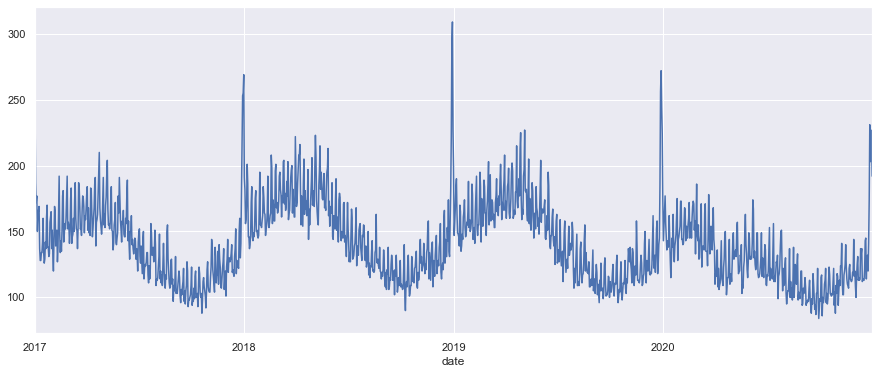

In [ ]:
df_brat['num_sold'].plot(figsize=(15,6))

### Analizando Tendencias

<AxesSubplot:xlabel='date'>

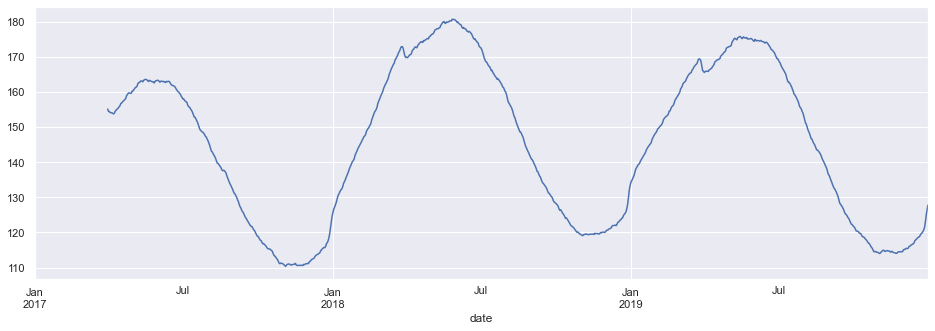

In [ ]:
df_brat_train['num_sold'].rolling(90).mean().plot(figsize=(16,5))

### Analizando a Sazonalidade

<AxesSubplot:xlabel='date'>

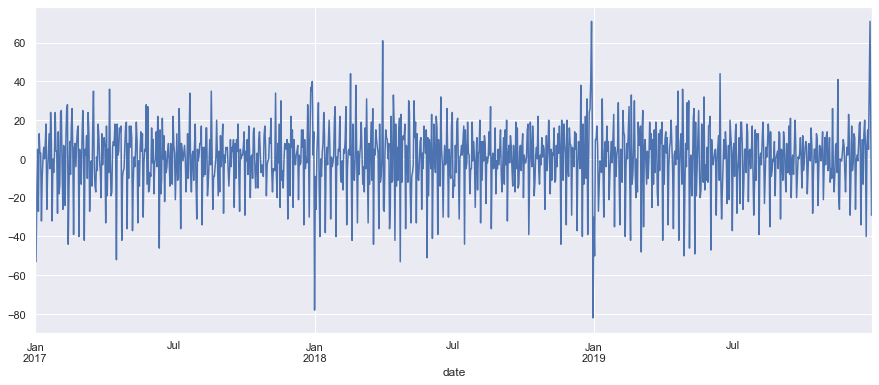

In [ ]:
df_brat_train['num_sold'].diff().plot(figsize=(15,6))

<AxesSubplot:xlabel='date'>

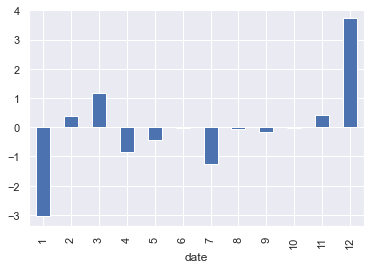

In [ ]:
df_brat_train['num_sold'].diff().groupby(df_brat_train.index.month).mean().plot(kind='bar')

In [ ]:
df_brat_train['num_sold'].index.month

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
           dtype='int64', name='date', length=1094)

### Criando regressão a partir da segmentacao dos dados, utilizando os dados temporais

In [ ]:
df_brat_train.columns

Index(['row_id', 'country', 'store', 'product', 'num_sold', 'sold-1',
       'sold-2'],
      dtype='object')

In [ ]:
drop = ['row_id', 'country', 'store', 'product', 'num_sold']
df_brat_train.dropna(axis=0, inplace=True)
X_train = df_brat_train.drop(columns=drop, axis=1)
y_train = df_brat_train['num_sold']
X_val = df_brat_val.drop(columns=drop, axis=1)
y_val = df_brat_val['num_sold']


dados_split = (X_train, X_val, y_train, y_val)
dados_train = (X_train, y_train)
dados_val = (X_val, y_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1093, 2), (1093,), (366, 2), (366,))

Média de Residuos (Quanto mais proximo de zero melhor)
Residuo Treino: -2.0828718438932856e-14 
Residuo Valid: -3.0056734245190517 

Teste de distribuição normal (Pvalor < 0.05)
Pvalor Treino:  1.22e-07 
Pvalor Valid:  0.0207

SMAP (Quanto menor melhor)
Treino:  8.6959862 
Valid:  9.3098053
 
 
Wall time: 350 ms


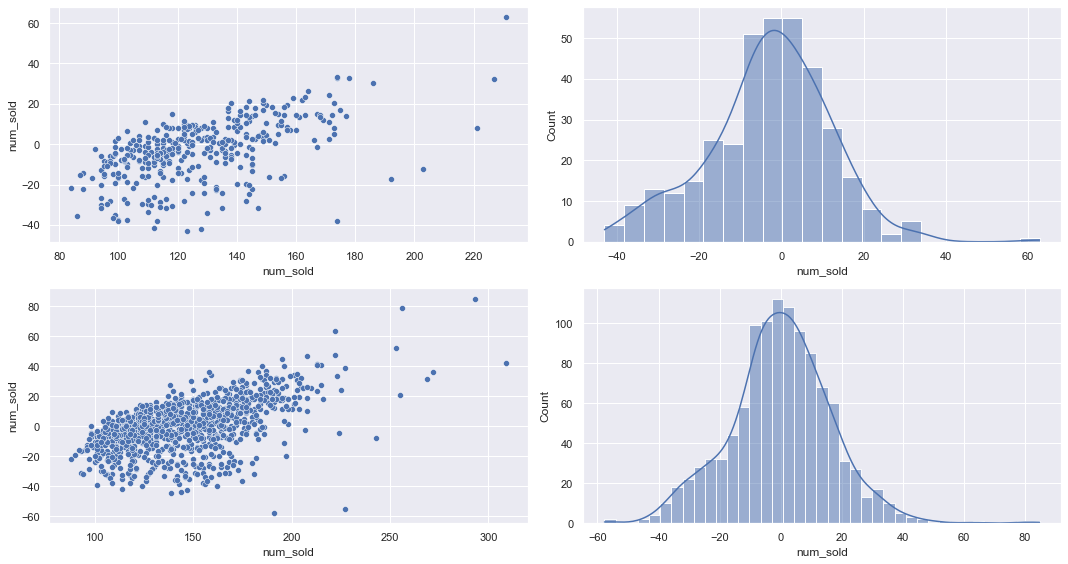

In [ ]:
%%time

modelo_basico = LinearRegression().fit(X_train, y_train)

avaliacao(modelo_basico, *dados_split)

### Criando uma funçao de auto regressao

In [ ]:
df_brat =  train[(train['product'] == 'Kaggle Advanced Techniques' ) &
                 (train['store'] == 'KaggleRama') &
                 (train['country'] == 'Belgium')].copy()

df_brat_test =  test[(test['product'] == 'Kaggle Advanced Techniques' ) &
                 (test['store'] == 'KaggleRama') &
                 (test['country'] == 'Belgium')].copy()

filtro = df_brat.index.year >= 2020
df_brat_val   = df_brat[filtro]

filtro = df_brat.index.year <= 2019
df_brat_train = df_brat[filtro]

In [ ]:
df_brat.shape[0]

1461

In [ ]:
df_brat_test

,row_id,country,store,product
date,,,,
2021-01-01,70132,Belgium,KaggleRama,Kaggle Advanced Techniques
2021-01-02,70180,Belgium,KaggleRama,Kaggle Advanced Techniques
2021-01-03,70228,Belgium,KaggleRama,Kaggle Advanced Techniques
2021-01-04,70276,Belgium,KaggleRama,Kaggle Advanced Techniques
2021-01-05,70324,Belgium,KaggleRama,Kaggle Advanced Techniques
...,...,...,...,...
2021-12-27,87412,Belgium,KaggleRama,Kaggle Advanced Techniques
2021-12-28,87460,Belgium,KaggleRama,Kaggle Advanced Techniques
2021-12-29,87508,Belgium,KaggleRama,Kaggle Advanced Techniques


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
def auto_regressao(train, test, y, identificador, shift):
    
    df = pd.concat([train, test])
    drop = list(df.columns)
    drop.remove(y)
    drop.remove(identificador)
    df.drop(columns=drop, axis=1, inplace=True)
    
    for t in range(shift):
        t+=1
        df[f"{y}_{t}"] = df[y].shift(t)
        t-=1

    X_train = df.drop(columns=list([identificador]), axis=1).copy()
    X_train.dropna(axis=0, inplace=True)
    X_train.drop(columns=y, axis=1, inplace=True)
    y_train = df.drop(columns=list([identificador]), axis=1).copy()
    y_train.dropna(axis=0, inplace=True)
    y_train.drop(columns=X_train.columns, axis=1, inplace=True)
    
    filtro = df.index.year >= 2021
    X_test = df[filtro]
    index = list(X_test['row_id'])
    X_test.drop(columns=['row_id', 'num_sold'], axis=1, inplace=True)
    
    modelo = LinearRegression(n_jobs=-1).fit(X_train, y_train)
    
    predic = list([])
    for i in range(X_test.shape[0]):
     
        previsao = modelo.predict(X_test.iloc[i:i+1])
        predic.append(previsao[0][0])
        
        a = i
        for coluna in X_test.columns:
            a+=1
            if a < X_test.shape[0]:
                X_test[coluna][a] = previsao
        
    y_test = pd.DataFrame({'row_id':index, 'num_sold': predic})
    
    return modelo, X_train, y_train, X_test, y_test

In [ ]:
filtro = df_brat.index.year >= 2020
df_brat_val   = df_brat[filtro]

filtro = df_brat.index.year <= 2019
df_brat_train = df_brat[filtro]

In [ ]:
%%time
colunas = ['row_id', 'num_sold']
df_submissao = pd.DataFrame(columns=colunas)
country = train['country'].unique()
store = train['store'].unique()
product = train['product'].unique()

for pais in country:
    for loja in store:
        for livro in product:
            print(pais, loja, livro)
            
            df_1 =  train[(train['product'] == livro ) &
                             (train['store'] == loja) &
                             (train['country'] == pais)].copy()
            
            filtro = df_brat.index.year >= 2020
            df_val   = df_brat[filtro]
            
            filtro = df_brat.index.year <= 2019
            df_train = df_brat[filtro]
            
            modelo, df_y = auto_regressao(df_treino, df_teste, 'num_sold', 'row_id', 2)
            
            y_pred_train = estimador.predict(X_train)
            y_pred_val = estimador.predict(X_val)

            smap_train = mean_absolute_percentage_error(y_train, y_pred_train)
            smap_val = mean_absolute_percentage_error(y_val, y_pred_val)

            residuo_train = y_train - y_pred_train
            residuo_val = y_val - y_pred_val

            _, p_train = normaltest(residuo_train)
            _, p_val = normaltest(residuo_val)

            print("Média de Residuos (Quanto mais proximo de zero melhor)")
            print(f"Residuo Treino: {residuo_train.mean():.8} \nResiduo Valid: {residuo_val.mean():.8} \n")
            print("Teste de distribuição normal (Pvalor < 0.05)")
            print(f"Pvalor Treino: {p_train: .8} \nPvalor Valid: {p_val: .8}")
            print("\nSMAP (Quanto menor melhor)")
            print(f"Treino: {100 * smap_train: .8} \nValid: {100 * smap_val: .8}")
            print(" \n ")
            

,row_id,num_sold


In [ ]:
%%time
colunas = ['row_id', 'num_sold']
df_submissao = pd.DataFrame(columns=colunas)
country = train['country'].unique()
store = train['store'].unique()
product = train['product'].unique()

for pais in country:
    for loja in store:
        for livro in product:
            print(pais, loja, livro)
            
            df_treino =  train[(train['product'] == livro ) &
                             (train['store'] == loja) &
                             (train['country'] == pais)].copy()
            
            df_teste =  test[(test['product'] == livro ) &
                             (test['store'] == loja) &
                             (test['country'] == pais)].copy()
            
            _, df_y = auto_regressao(df_treino, df_teste, 'num_sold', 'row_id', 200)
            
            df_submissao = pd.concat([df_submissao, df_y]).sort_values(by='row_id')

comp = ".csv"
local = 'Submissoes/'
nome = 'LinearSVR_1'
df_submissao.to_csv(end + local + nome + comp, header=True, index=False)
print(f'Arquivo salvo com sucesso! em: {end + local}')

df_submissao

Belgium KaggleMart Kaggle Advanced Techniques
Belgium KaggleMart Kaggle Getting Started
Belgium KaggleMart Kaggle Recipe Book
Belgium KaggleMart Kaggle for Kids: One Smart Goose
Belgium KaggleRama Kaggle Advanced Techniques
Belgium KaggleRama Kaggle Getting Started
Belgium KaggleRama Kaggle Recipe Book
Belgium KaggleRama Kaggle for Kids: One Smart Goose
France KaggleMart Kaggle Advanced Techniques
France KaggleMart Kaggle Getting Started
France KaggleMart Kaggle Recipe Book
France KaggleMart Kaggle for Kids: One Smart Goose
France KaggleRama Kaggle Advanced Techniques
France KaggleRama Kaggle Getting Started
France KaggleRama Kaggle Recipe Book
France KaggleRama Kaggle for Kids: One Smart Goose
Germany KaggleMart Kaggle Advanced Techniques
Germany KaggleMart Kaggle Getting Started
Germany KaggleMart Kaggle Recipe Book
Germany KaggleMart Kaggle for Kids: One Smart Goose
Germany KaggleRama Kaggle Advanced Techniques
Germany KaggleRama Kaggle Getting Started
Germany KaggleRama Kaggle Reci

,row_id,num_sold
0,70128,562.075625
0,70129,417.252624
0,70130,392.076077
0,70131,544.694631
0,70132,187.746809
...,...,...
364,87643,777.837762
364,87644,165.417183
364,87645,233.919285
364,87646,131.420887
